In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set the style for the plots
sns.set_palette("viridis")
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams['axes.grid'] = True

In [2]:
# Load the external dataset
def load_data(filepath, name):
    df = pd.read_csv(filepath)
    print(f"{name} data loaded successfully with {df.shape[0]} rows and {df.shape[1]} columns.")
    return df

external = load_data("../data/interim/cleaned_external_data.csv", "external")

external data loaded successfully with 2029 rows and 3 columns.


In [3]:
# Provide a structured overview to detect potential anomalies that could impact further analysis
def dataframe_summary(df: pd.DataFrame) -> pd.DataFrame:
    summary = pd.DataFrame({
        "Data Type": df.dtypes,
        "Non-Null Count": df.notnull().sum(),
        "Missing Values": df.isnull().sum(),
        "Distinct Values": df.nunique(),
        "Zeros Count": (df == 0).sum(),
        "Negative Values": (df < 0).sum(),
        "Infinite Values": np.isinf(df).sum()
    })

    print(summary)

In [4]:
# Get the descriptive statistics
external.describe()

,Tg,Ta,Tc
count,2029.000000,2029.000000,2029.000000
mean,34.368379,24.107541,37.029428
std,0.738554,1.324160,0.510204
min,30.225000,20.200000,35.540000
25%,33.955000,23.400000,36.790000
50%,34.387500,24.000000,36.940000
75%,34.787500,24.700000,37.140000
max,37.693333,29.100000,40.340000


In [5]:
# Get the detailed summary
dataframe_summary(external)

   Data Type  Non-Null Count  Missing Values  Distinct Values  Zeros Count  \
Tg   float64            2029               0             1215            0   
Ta   float64            2029               0               78            0   
Tc   float64            2029               0               70            0   

    Negative Values  Infinite Values  
Tg                0                0  
Ta                0                0  
Tc                0                0  


In [6]:
# Segment Tg based on temperature ranges
def segment_tg(df):
    # Conditions for segmentation:
    #   - 'lower': Tg between 31 (inclusive) and 33 (exclusive)
    #   - 'mid': Tg between 33 (inclusive) and 35 (exclusive)
    #   - 'higher': Tg between 35 (inclusive) and 37 (exclusive)
    conditions = [
        (df['Tg'] >= 31) & (df['Tg'] < 33),
        (df['Tg'] >= 33) & (df['Tg'] < 35),
        (df['Tg'] >= 35) & (df['Tg'] < 37)
    ]
    choices = ['lower', 'mid', 'higher']
    df['Tg_segment'] = np.select(conditions, choices, default='out_of_range')
    return df

# Segment Tg
external_segmented = segment_tg(external)

# Define a categorical ordering for the segments
segment_order = ['lower', 'mid', 'higher', 'out_of_range']
external_segmented['Tg_segment'] = pd.Categorical(
    external_segmented['Tg_segment'], categories=segment_order, ordered=True
)

In [7]:
# Sort the data first by segment and then by the Tg value
external_segmented_sorted = external_segmented.sort_values(by=['Tg_segment', 'Tg'], ascending=True)

print(external_segmented_sorted)

             Tg    Ta     Tc    Tg_segment
166   31.280000  22.8  36.44         lower
1621  31.302500  23.6  36.54         lower
1252  31.340000  23.0  36.59         lower
1323  31.412500  26.7  36.94         lower
1238  31.463333  22.7  37.34         lower
...         ...   ...    ...           ...
122   36.975000  23.2  40.34        higher
1189  30.225000  22.8  36.44  out_of_range
1144  37.136667  23.2  40.34  out_of_range
799   37.212500  28.6  39.54  out_of_range
1808  37.693333  28.6  39.54  out_of_range

[2029 rows x 4 columns]


In [8]:
segment_counts = external_segmented_sorted['Tg_segment'].value_counts(sort=False)
print("Number of Records Based on Tg Segments")
print(segment_counts)

Number of Records Based on Tg Segments
Tg_segment
lower             71
mid             1643
higher           311
out_of_range       4
Name: count, dtype: int64


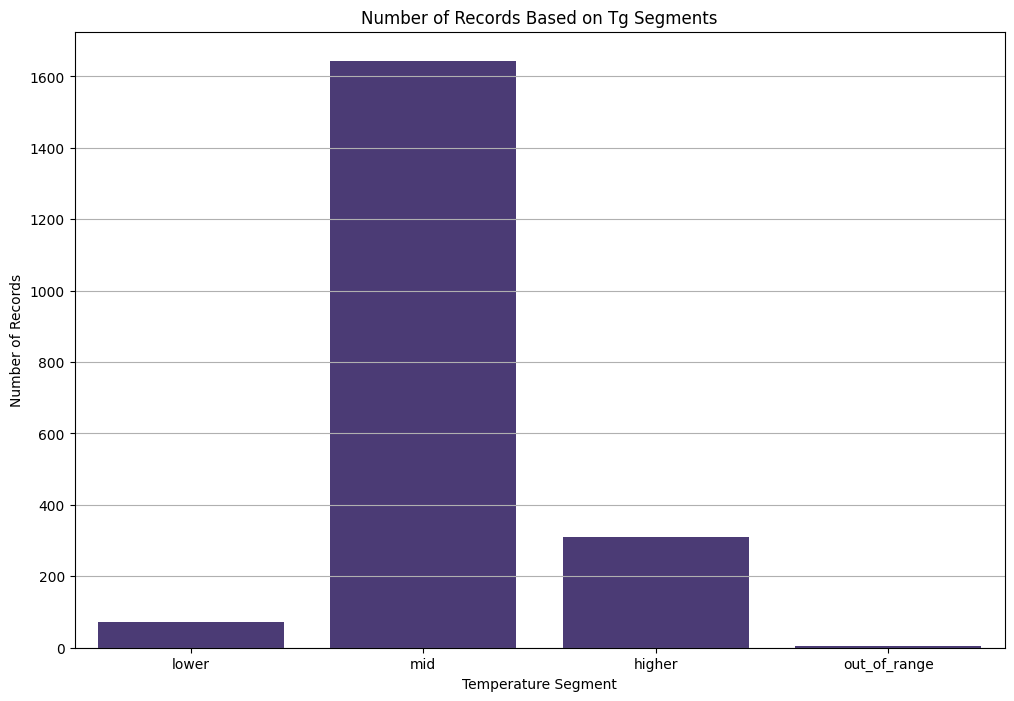

In [9]:
# Ensure the directory exists
os.makedirs('../reports/figures', exist_ok=True)

# Add visualization counting the number of records based on segments
plt.figure()
sns.barplot(x=segment_counts.index, y=segment_counts.values)

plt.xlabel("Temperature Segment")
plt.ylabel("Number of Records")
plt.title("Number of Records Based on Tg Segments")

# Save the figure automatically to the specified directory
plt.savefig('../reports/figures/number_of_records_based_on_tg_segments.png', dpi=300, bbox_inches='tight')

plt.show()